In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import matplotlib.pyplot as plt

# Définir les chemins des fichiers
raster_path = "../results/data/img_pretraitees/Serie_temp_S2_ndvi.tif"
shp_path = "../results/data/sample/Sample_BD_foret_T31TCJ.shp"
output_path = "../results/figure"
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, "temp_mean_ndvi.png")

In [2]:
# Charger le shapefile
gdf = gpd.read_file(shp_path)

# Filtrer pour ne conserver que les valeurs spécifiques
allowed_values = ["Chêne", "Robinier", "Peupleraie", "Douglas", "Pin laricio ou pin noir", "Pin maritime"]
gdf = gdf[gdf["Nom_pixel"].isin(allowed_values)]

# Charger le raster
dataset = gdal.Open(raster_path)
ndvi_stack = np.array([dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)])
transform = dataset.GetGeoTransform()

/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [3]:
# Calculer les centroïdes des géométries du shapefile
centroids = gdf.geometry.centroid  # Calculer les centroïdes
coords = [(centroid.x, centroid.y) for centroid in centroids]
nom_pixels = gdf['Nom_pixel']

# Convertir les coordonnées en indices de pixels
def world_to_pixel(transform, x, y):
    px = int((x - transform[0]) / transform[1])
    py = int((y - transform[3]) / transform[5])
    return px, py

pixel_indices = [world_to_pixel(transform, x, y) for x, y in coords]

# Vérifier les indices des pixels et filtrer ceux qui sont hors des limites du raster
valid_pixel_indices = []
valid_nom_pixels = []

for name, (row, col) in zip(nom_pixels, pixel_indices):
    if 0 <= row < ndvi_stack.shape[1] and 0 <= col < ndvi_stack.shape[2]:
        valid_pixel_indices.append((row, col))
        valid_nom_pixels.append(name)

# Extraire les valeurs NDVI uniquement pour les pixels valides et non-Nodata
ndvi_values = {name: [] for name in allowed_values}

# Filtrer les valeurs Nodata
no_data_value = -9999

for name, (row, col) in zip(valid_nom_pixels, valid_pixel_indices):
    pixel_values = ndvi_stack[:, row, col]
    valid_values = pixel_values[pixel_values != no_data_value]
    if len(valid_values) > 0:
        ndvi_values[name].append(valid_values)

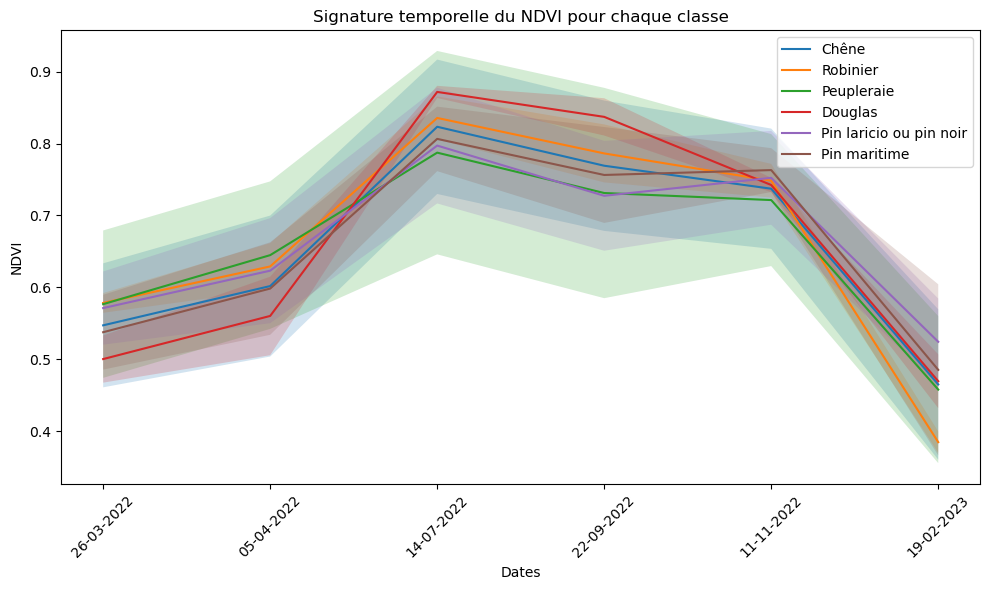

Graphique sauvegardé : ../results/figure/temp_mean_ndvi.png


In [4]:
dates = [
    "26-03-2022", "05-04-2022", "14-07-2022", "22-09-2022", "11-11-2022", "19-02-2023"
]

# Calculer la moyenne et l'écart-type pour chaque date et chaque classe
mean_values = {class_name: [] for class_name in allowed_values}
std_values = {class_name: [] for class_name in allowed_values}

for class_name in allowed_values:
    for i in range(len(dates)):
        values_for_date = np.array(ndvi_values[class_name])[:, i]  # Valeurs NDVI pour une classe à une date spécifique
        mean_values[class_name].append(values_for_date.mean())
        std_values[class_name].append(values_for_date.std())

# Créer un graphique avec Matplotlib
plt.figure(figsize=(10, 6))

# Tracer les moyennes et les écarts-types pour chaque classe
for class_name in allowed_values:
    plt.plot(range(len(dates)), mean_values[class_name], label=class_name)
    plt.fill_between(
        range(len(dates)),
        np.array(mean_values[class_name]) - np.array(std_values[class_name]),
        np.array(mean_values[class_name]) + np.array(std_values[class_name]),
        alpha=0.2
    )

# Personnalisation du graphique
plt.title("Signature temporelle du NDVI pour chaque classe")
plt.xlabel("Dates")
plt.ylabel("NDVI")
plt.xticks(ticks=range(len(dates)), labels=dates, rotation=45)  # Utilisation des dates comme étiquettes
plt.legend(loc='upper right')

# Sauvegarder et afficher le graphique
plt.tight_layout()
plt.savefig(output_file)
plt.show()

print(f"Graphique sauvegardé : {output_file}")